# Vehicle Detection
Note that training data needs to be downloaded:

https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip

https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip

These should be extracted to `./training_data`

In [1]:
import math
import matplotlib.image as mpimg
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

%matplotlib inline

images = [
    mpimg.imread('training_data/vehicles/GTI_MiddleClose/image0000.png'),
    mpimg.imread('training_data/vehicles/GTI_Far/image0000.png'),
    mpimg.imread('training_data/vehicles/GTI_Left/image0009.png'),
    mpimg.imread('training_data/vehicles/GTI_Right/image0000.png'),
    mpimg.imread('training_data/vehicles/KITTI_extracted/1.png'),
]

## Histogram of Oriented Gradient (HOG) features
HOG features are extracted from the images by using the scikit image hog function. These parameters were tuned through a trial and error process to find effective values.

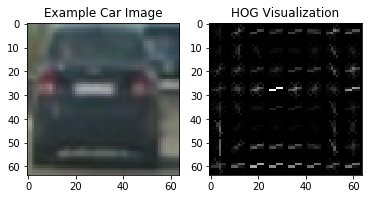

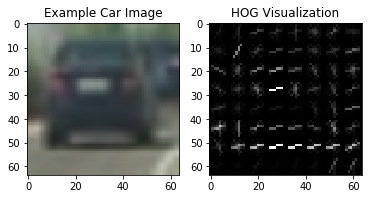

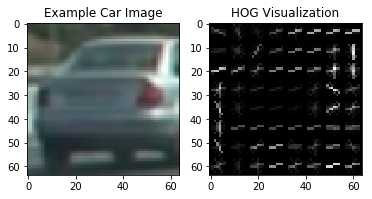

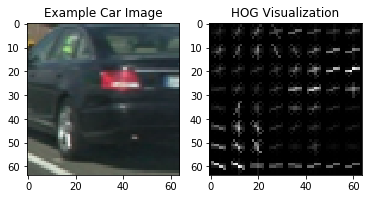

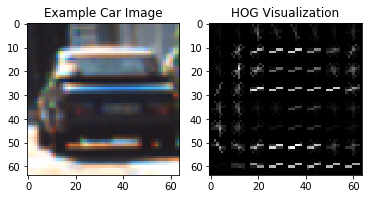

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    return hog(img, orientations=orient, 
                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                  cells_per_block=(cell_per_block, cell_per_block), 
                  transform_sqrt=True, 
                  visualise=vis, feature_vector=feature_vec)

ORIENT = 9  # HOG orientations
PIX_PER_CELL = 8 # HOG pixels per cell
CELL_PER_BLOCK = 2 # HOG cells per block

# Plot the examples
for image in images:
    # Call our function with vis=True to see an image output
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    features, hog_image = get_hog_features(gray, ORIENT, 
                        PIX_PER_CELL, CELL_PER_BLOCK, 
                        vis=True, feature_vec=False)

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(image, cmap='gray')
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Visualization')

## Binned color features
Binned color features were extracted by reducing the size of the image, then flattening the image into a vector. The resized shape was determined through trial and error.

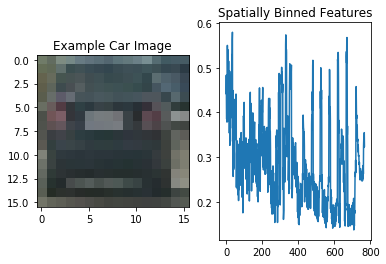

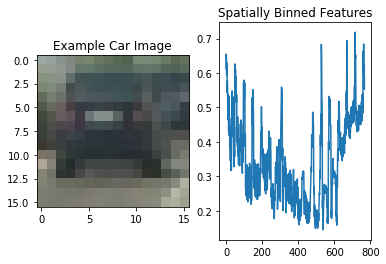

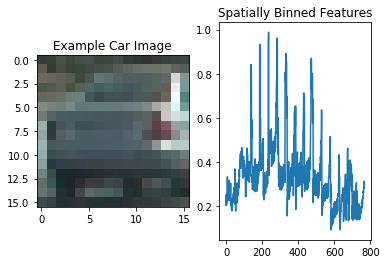

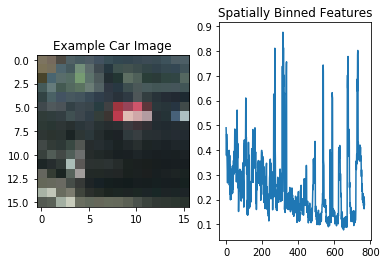

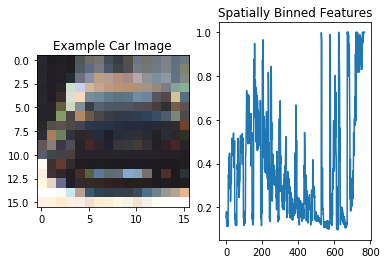

In [3]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

SPATIAL_SIZE = (16, 16) # Spatial binning dimensions

for image in images:
    feature_vec = bin_spatial(image, SPATIAL_SIZE)

    # Plot features
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(cv2.resize(image, SPATIAL_SIZE))
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.plot(feature_vec)
    plt.title('Spatially Binned Features')

## Color histogram
A histogram of the colors of the image is also created. First the image is converted to a different color space. It was found that YCrCb gives good results. Then the values are binned for each channel.

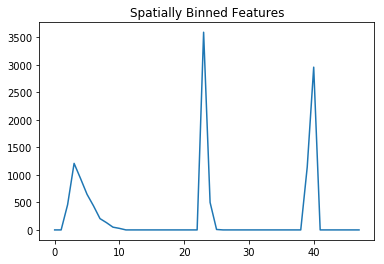

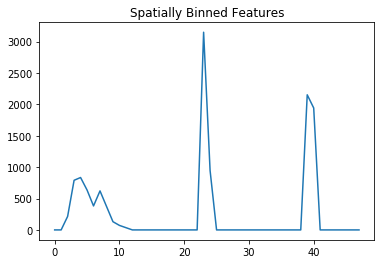

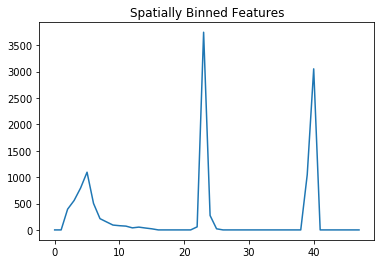

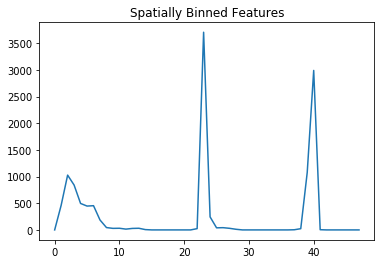

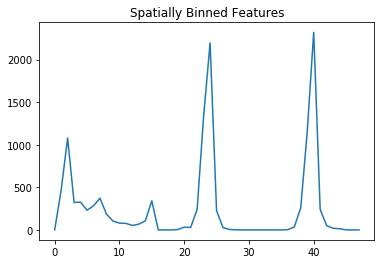

In [4]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

HIST_BINS = 16    # Number of histogram bins

for image in images:
    feature_vec = color_hist(cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb), HIST_BINS)
    
    # Plot features
    plt.figure()
    plt.plot(feature_vec)
    plt.title('Spatially Binned Features')

## Feature extraction
The following code is a pipeline to extract features from images. First, the color space is converted, then spatial, color histogra and HoG features are computed. A batch function is also supplied, which reads in a file, then computes features for both the raw image and a flipped version. The flipping is done to augment the dataset.

In [5]:
# Define a function to extract features from a single image window
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        features.append(single_img_features(image, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat))
        features.append(single_img_features(np.fliplr(image), color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat))
    # Return list of feature vectors
    return features

## Training
Training consists of reading in car and non-car examples, then training a support vector machine classifier on the data. Prior to training, the data is split into training and test sets, centered and normalized. The largest portion of time is spent extracting the features from the images.

In [6]:
# Read in cars and notcars
cars = glob.glob('training_data/vehicles/**/*.png', recursive=True)
notcars = glob.glob('training_data/non-vehicles/**/*.png', recursive=True)

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV(0.9673), LUV(0.9828), HLS(0.9628), YUV(0.9789), YCrCb(0.9825, great results)

hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

print("Extracting car features")
t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=SPATIAL_SIZE, hist_bins=HIST_BINS, 
                        orient=ORIENT, pix_per_cell=PIX_PER_CELL, 
                        cell_per_block=CELL_PER_BLOCK, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract...')
print("Extracting car features")
t=time.time()
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=SPATIAL_SIZE, hist_bins=HIST_BINS, 
                        orient=ORIENT, pix_per_cell=PIX_PER_CELL, 
                        cell_per_block=CELL_PER_BLOCK, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract...')
print("Extracting non-car features")

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',ORIENT,'orientations',PIX_PER_CELL,
    'pixels per cell and', CELL_PER_BLOCK,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Extracting car features
64.17 Seconds to extract...
Extracting car features
65.79 Seconds to extract...
Extracting non-car features
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
18.65 Seconds to train SVC...
Test Accuracy of SVC =  0.9831


## Searching over the image
To try to find cars in an image, the classifier is run over a number of windows on the image. Different sized windows are used to try to capture cars at different distances. The various windows can be seen below.

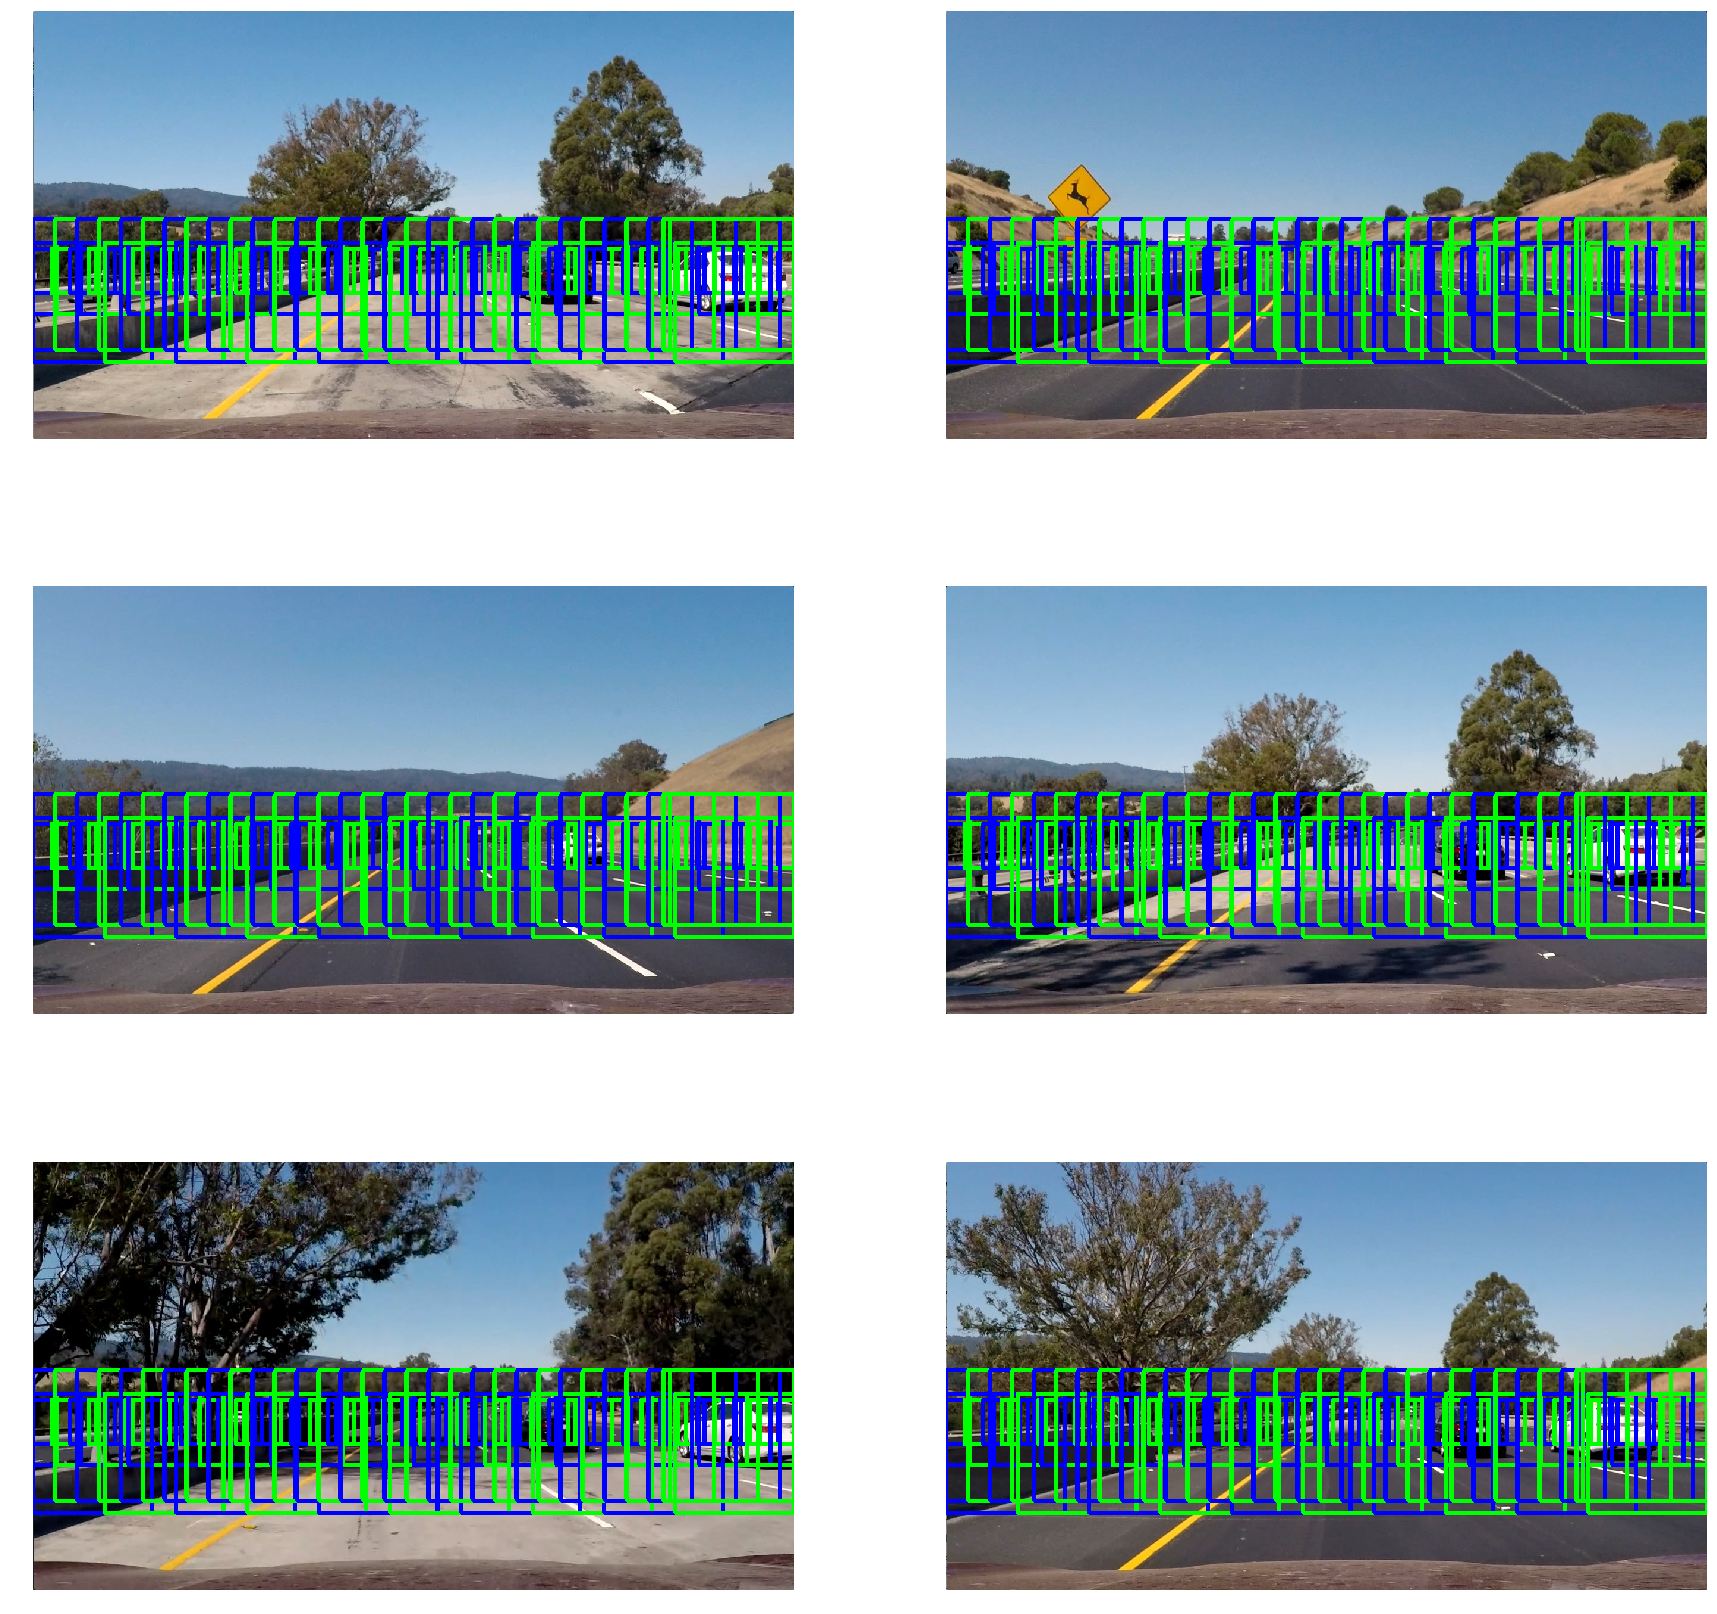

In [7]:
def stride_windows(img, win_size, num_win_x, y_top):
    x_right = img.shape[1] - win_size
    x_stride = int(round(x_right / (num_win_x-1)))
    windows = []
    for xs in range(num_win_x-1):
        windows.append(((xs*x_stride, y_top), (xs*x_stride+win_size, y_top+win_size)))
    # Make sure that the last window is pushed all the way to the edge
    windows.append(((x_right, y_top),(img.shape[1], y_top+win_size)))
    return windows

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    colors = [(0, 0, 255), (0, 255, 0)]
    for idx, bbox in enumerate(bboxes):
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], colors[idx%2], thick)
    # Return the image copy with boxes drawn
    return imcopy

def form_windows(image):
    windows = []
    coords = [
        (75, 40, 400),
        (120, 30, 390),
        (200, 10, 390),
        (220, 30, 350),
    ]
    for win_size, num_win_x, y_top in coords:
        windows.extend(stride_windows(image, win_size, num_win_x, y_top))
    return windows

images = glob.glob('test_images/test*.jpg')
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(30,30))
cnt = 0
for ax in axs:
    for x in ax:
        img = mpimg.imread(images[cnt])
        windows = form_windows(img)
        window_img = draw_boxes(img, windows, color=(0, 0, 255), thick=6) 
        # Convert to uint8 so that imshow displays properly
        x.imshow(window_img.astype(np.uint8))
        x.axis('off')
        cnt += 1
plt.show()

## Searching and thresholding
Below are a few functions which are used to actually perform the classification. False-positives and overlapping windows are handled by creating a heatmap of found patches. A threshold is then used to ensure that only those found windows will be returned if they overlap sufficient amount.

In [8]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Pipeline
The pipeline which classifies each image is defined below.

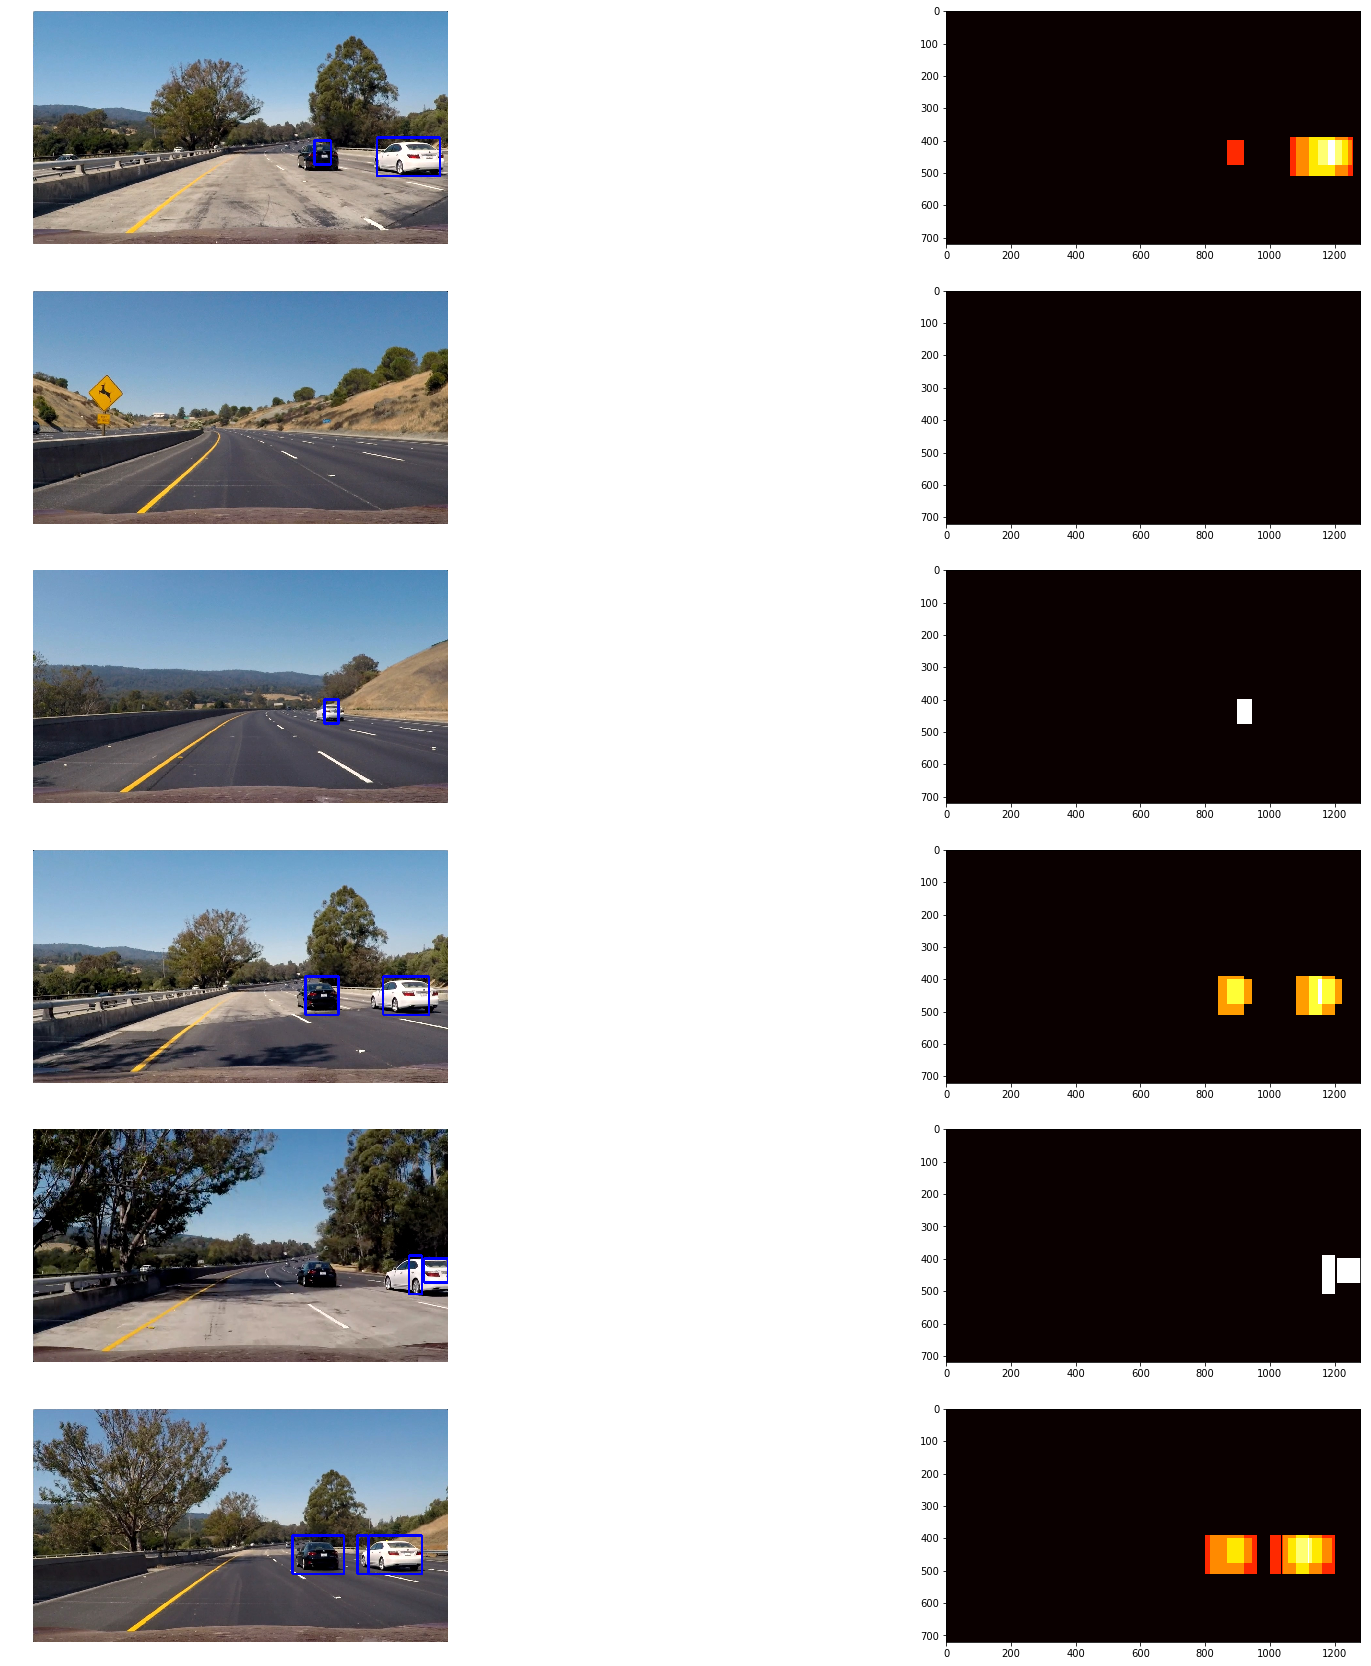

In [9]:
def pipeline(image, return_heatmap=False):
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    windows = form_windows(image)

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=SPATIAL_SIZE, hist_bins=HIST_BINS, 
                            orient=ORIENT, pix_per_cell=PIX_PER_CELL, 
                            cell_per_block=CELL_PER_BLOCK, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image)*255, labels)
    if return_heatmap:
        return draw_img, heatmap
    return draw_img

images = glob.glob('test_images/test*.jpg')
fig, axs = plt.subplots(len(images), 2, figsize=(30,30))
cnt = 0
for cnt, ax in enumerate(axs):
    img = mpimg.imread(images[cnt])
    draw_img, heatmap = pipeline(img, True)
    # Convert to uint8 so that imshow displays properly
    ax[0].imshow(draw_img.astype(np.uint8))
    ax[0].axis('off')
    ax[1].imshow(heatmap, cmap='hot')
plt.show()

## Video

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def nothing(img):
    return img
white_output = './fitted.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./fitted.mp4
[MoviePy] Writing video ./fitted.mp4


100%|█████████▉| 1260/1261 [06:40<00:00,  4.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./fitted.mp4 

CPU times: user 5min 19s, sys: 26.6 s, total: 5min 45s
Wall time: 6min 42s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Discussion
The classifier performs reasonably finding images in the video. The bounding box is somewhat unstable, which could be improved by using some sort of low-pass filtering mechanism. 
The classifier also appears to detect cars on the other side of the road, which may not be desirable. However, with steady bounding boxes, it should be simple to detect that they are traveling in the opposite direction by computing their trajectory. 